This notebook is part of [**Byron v0.1**](https://github.com/cad-polito-it/byron)  
Copyright 2023 Giovanni Squillero and Alberto Tonda  
SPDX-License-Identifier: [Apache-2.0](https://www.tldrlegal.com/license/apache-license-2-0-apache-2-0) 

In [1]:
import byron

/var/folders/31/dkl97hks2c14b663vl55pt440000gn/T/ipykernel_2751/1429530752.py:1: ByronPerformanceWarning: 
  Paranoia checks are enabled in this notebook: performances can be significantly impaired
  [see https://github.com/cad-polito-it/byron/blob/pre-alpha/docs/paranoia.md for details]
  import byron


Everything for the definition of the constraints (the old "instruction library") is under the namespace `byron.framework` (lazy fingers can use `byron.f`)

# Global References

Global references specify the target frame (notez bien: a frame may contains sub frames)

## *Internal* Global References

A reference to a different frame in the same subtree.

; 🖋 n1 ➜ Frame❬FrameSequence#1❭
; 🖋 n1.n2 ➜ Frame❬MacroArray#1❭
foo #dbcd  ; 🖋 n1.n2.n3 ➜ Macro❬User#1❭
foo #b286  ; 🖋 n1.n2.n4 ➜ Macro❬User#1❭
n5:
foo #181c  ; 🖋 n1.n2.n5 ➜ Macro❬User#1❭
n6:
foo #f9c2  ; 🖋 n1.n2.n6 ➜ Macro❬User#1❭
foo #c2da  ; 🖋 n1.n2.n7 ➜ Macro❬User#1❭
; 🖋 n1.n8 ➜ Frame❬MacroArray#2❭
global_ref: n6  ; 🖋 n1.n8.n9 ➜ Macro❬User#3❭
global_ref: n6  ; 🖋 n1.n8.n10 ➜ Macro❬User#3❭
global_ref: n5  ; 🖋 n1.n8.n11 ➜ Macro❬User#3❭


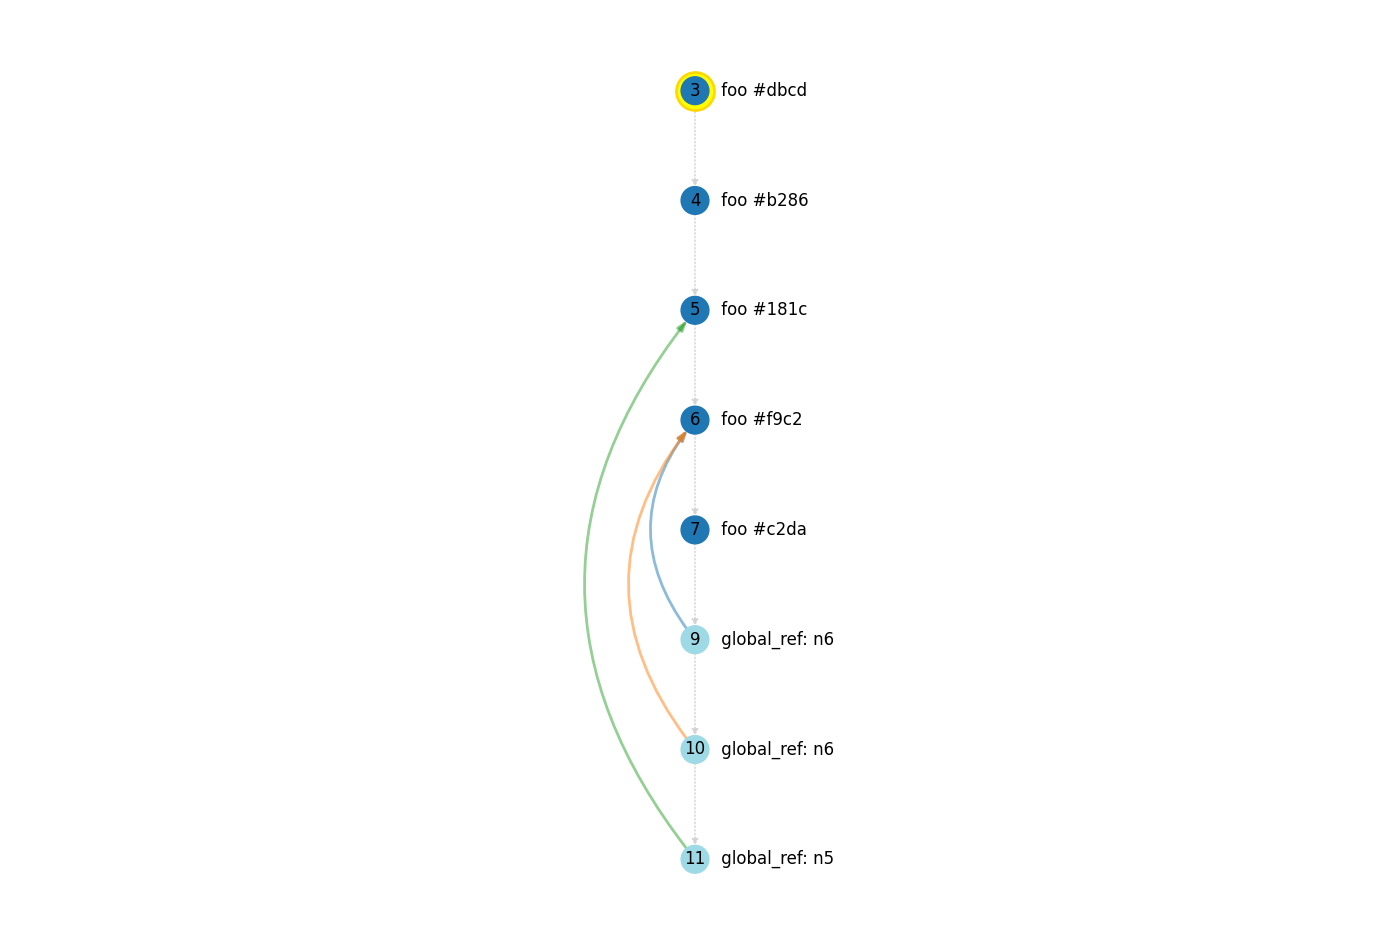

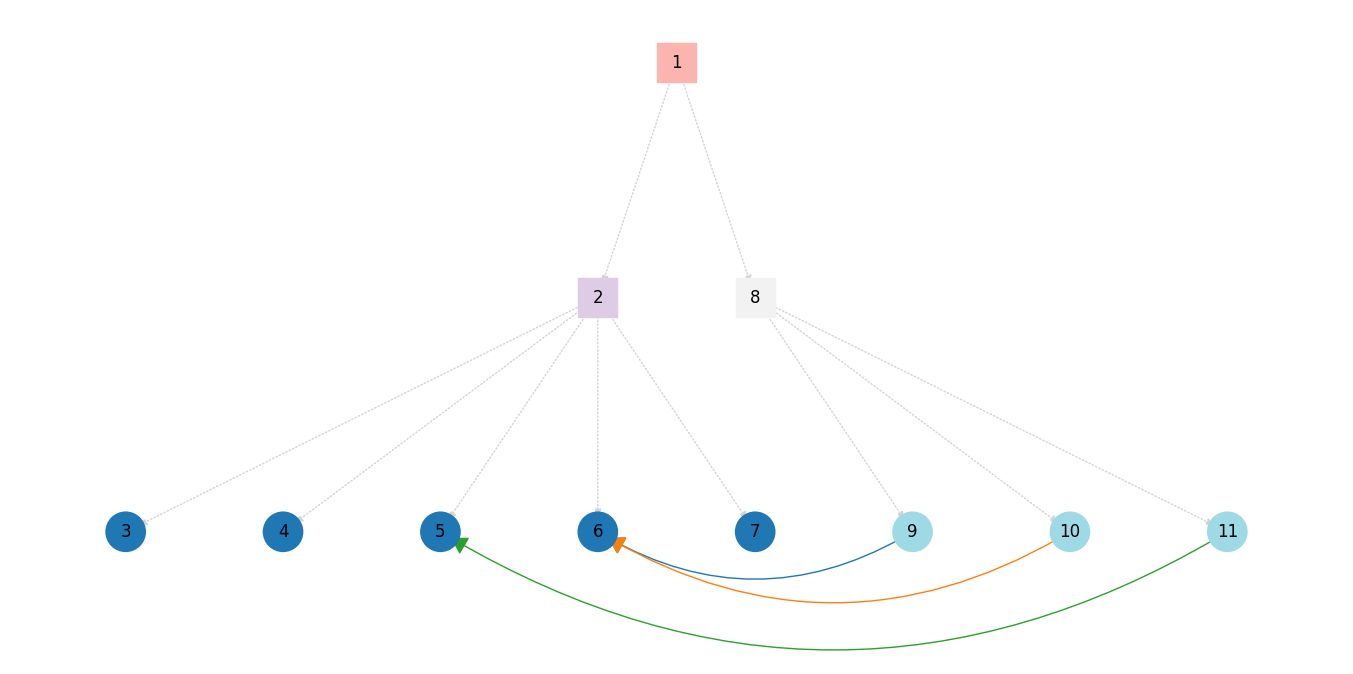

In [2]:
macro_foo = byron.f.macro('foo #{num:04x}', num=byron.f.integer_parameter(0, 2 ** 16))
macro_bar = byron.f.macro('bar {num:+0.2g}', num=byron.f.float_parameter(-1, 1))

foo_bunch = byron.f.bunch([macro_foo], size=5)
macro_ref = byron.f.macro('global_ref: {ref}', ref=byron.f.global_reference(foo_bunch))
ref_bunch = byron.f.bunch([macro_ref], size=3)
program = byron.f.sequence([foo_bunch, ref_bunch])

byron.f.as_text(program)
byron.f.as_lgp(program)
byron.f.as_forest(program)

References may use the `frame` class or the name of a *frame class* (see *string magic* with frames). Remember that all names are **unique** (thus they me defined only once).

In [3]:
macro_foo = byron.f.macro('foo #{num:04x}', num=byron.f.integer_parameter(0, 2 ** 16))
macro_ref = byron.f.macro('global_ref: {ref}', ref=byron.f.global_reference('foo_bunch_name'))

foo_bunch = byron.f.bunch([macro_foo], size=5, name='foo_bunch_name')
ref_bunch = byron.f.bunch([macro_ref], size=3)
program = byron.f.sequence([foo_bunch, ref_bunch])

byron.f.as_text(program)

; 🖋 n1 ➜ Frame❬FrameSequence#2❭
; 🖋 n1.n2 ➜ Frame<foo_bunch_name>
foo #dbcd  ; 🖋 n1.n2.n3 ➜ Macro❬User#1❭
foo #b286  ; 🖋 n1.n2.n4 ➜ Macro❬User#1❭
n5:
foo #181c  ; 🖋 n1.n2.n5 ➜ Macro❬User#1❭
n6:
foo #f9c2  ; 🖋 n1.n2.n6 ➜ Macro❬User#1❭
foo #c2da  ; 🖋 n1.n2.n7 ➜ Macro❬User#1❭
; 🖋 n1.n8 ➜ Frame❬MacroArray#3❭
global_ref: n6  ; 🖋 n1.n8.n9 ➜ Macro❬User#4❭
global_ref: n6  ; 🖋 n1.n8.n10 ➜ Macro❬User#4❭
global_ref: n5  ; 🖋 n1.n8.n11 ➜ Macro❬User#4❭


## *External* Global References

A reference to a different frame in a different subtree. The `global_reference` must be allowed to create new frames. The *creative_zeal* $z$ defines the willingness to create new trees: if $z$ is an integer, then the probability to create the target $T_{n+1}$ if $n$ compatible targets $T_0, T_1, ..., T_n$ already exist is $p=1-\frac{n}{n+z}$; if $z$ is a float, then the probability is simply $p = z$. If $p > 0$ and $n=0$ then the first tree is always created. 

; 🖋 n1 ➜ Frame❬MacroArray#5❭
GOTO n10  ; 🖋 n1.n2 ➜ Macro❬User#5❭
foo #20cc  ; 🖋 n1.n3 ➜ Macro❬User#1❭
foo #734c  ; 🖋 n1.n4 ➜ Macro❬User#1❭
GOTO n10  ; 🖋 n1.n5 ➜ Macro❬User#5❭
foo #ed40  ; 🖋 n1.n6 ➜ Macro❬User#1❭
; 🖋 n7 ➜ Frame❬MacroArray#4❭
bar +0.95  ; 🖋 n7.n8 ➜ Macro❬User#2❭
bar +0.52  ; 🖋 n7.n9 ➜ Macro❬User#2❭
n10:
bar +0.57  ; 🖋 n7.n10 ➜ Macro❬User#2❭


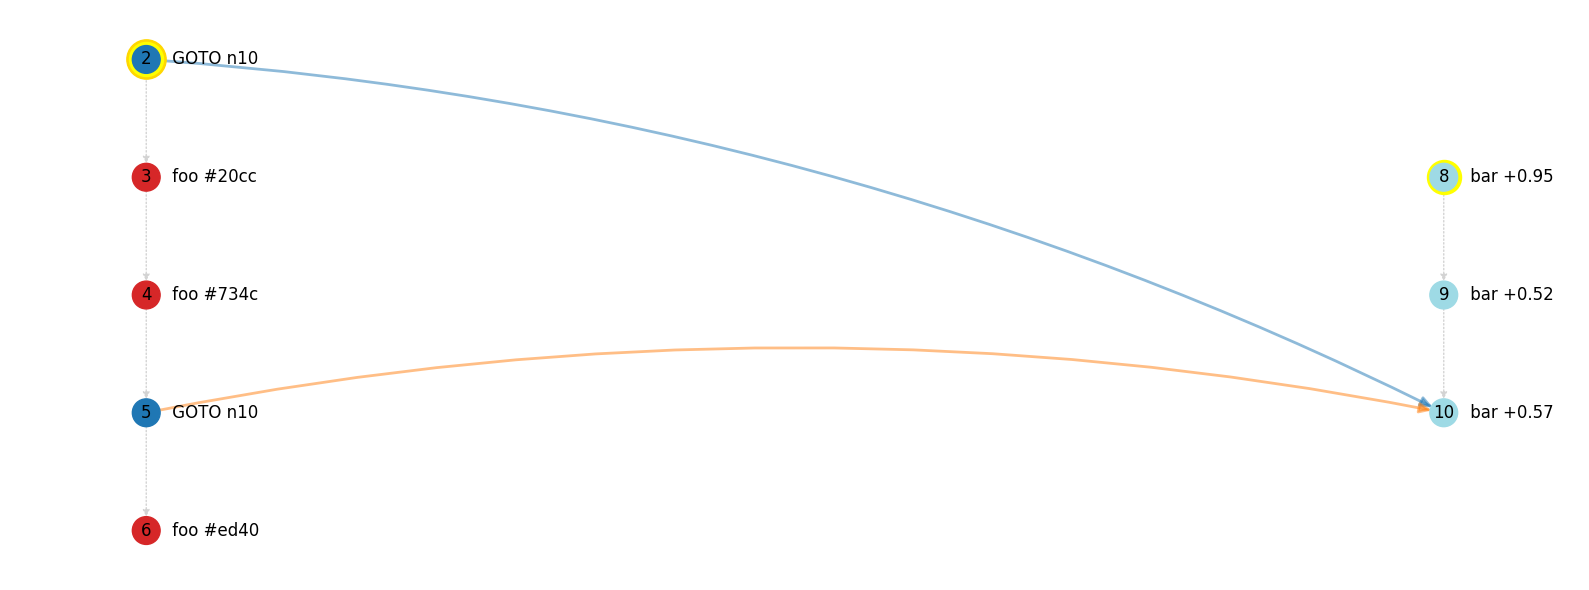

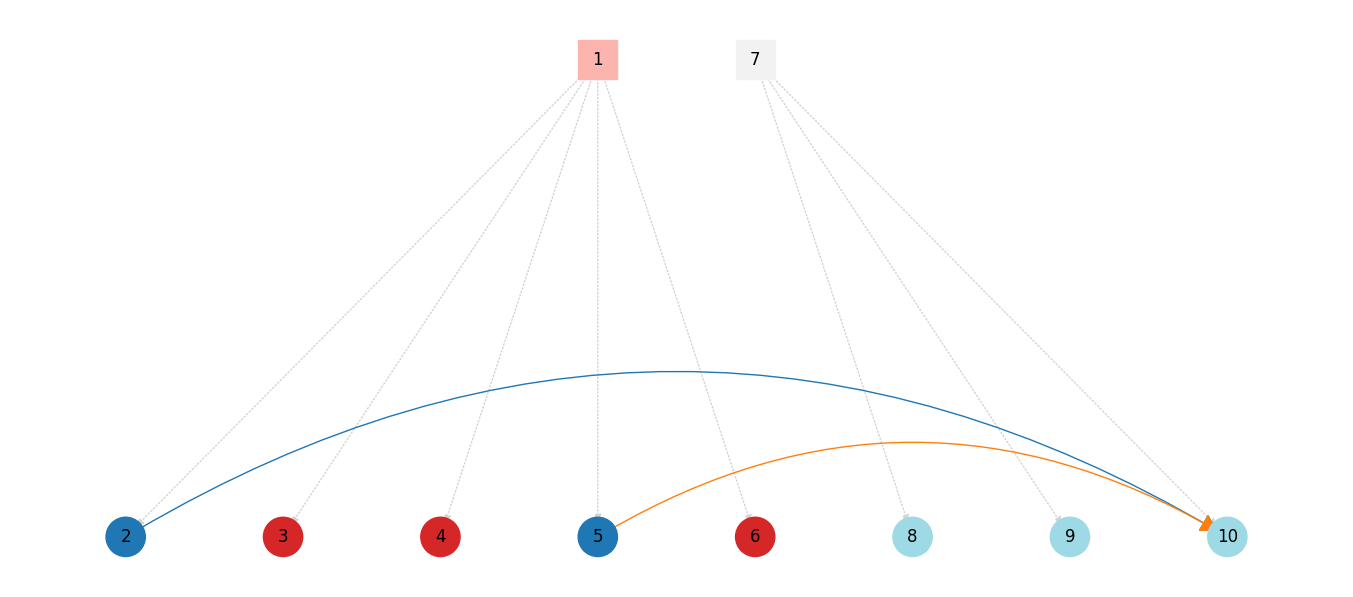

In [4]:
macro_foo = byron.f.macro('foo #{num:04x}', num=byron.f.integer_parameter(0, 2 ** 16))
macro_bar = byron.f.macro('bar {num:+0.2g}', num=byron.f.float_parameter(-1, 1))
external_frame = byron.f.bunch([macro_bar], size=3)
macro_ref = byron.f.macro('GOTO {ref}', ref=byron.f.global_reference(external_frame, creative_zeal=1))
main_frame = byron.f.bunch([macro_foo, macro_ref], size=5)

byron.f.as_text(main_frame)
byron.f.as_lgp(main_frame)
byron.f.as_forest(main_frame)

Global references may be forced to always hit the very first maco in a frame

; 🖋 n1 ➜ Frame❬MacroArray#7❭
CALL n8  ; 🖋 n1.n2 ➜ Macro❬User#6❭
foo #20cc  ; 🖋 n1.n3 ➜ Macro❬User#1❭
foo #734c  ; 🖋 n1.n4 ➜ Macro❬User#1❭
CALL n12  ; 🖋 n1.n5 ➜ Macro❬User#6❭
foo #3a2c  ; 🖋 n1.n6 ➜ Macro❬User#1❭
; 🖋 n7 ➜ Frame❬MacroArray#6❭
n8:
bar +0.95  ; 🖋 n7.n8 ➜ Macro❬User#2❭
bar +0.52  ; 🖋 n7.n9 ➜ Macro❬User#2❭
bar +0.57  ; 🖋 n7.n10 ➜ Macro❬User#2❭
; 🖋 n11 ➜ Frame❬MacroArray#6❭
n12:
bar +0.85  ; 🖋 n11.n12 ➜ Macro❬User#2❭
bar +0.29  ; 🖋 n11.n13 ➜ Macro❬User#2❭
bar +0.65  ; 🖋 n11.n14 ➜ Macro❬User#2❭


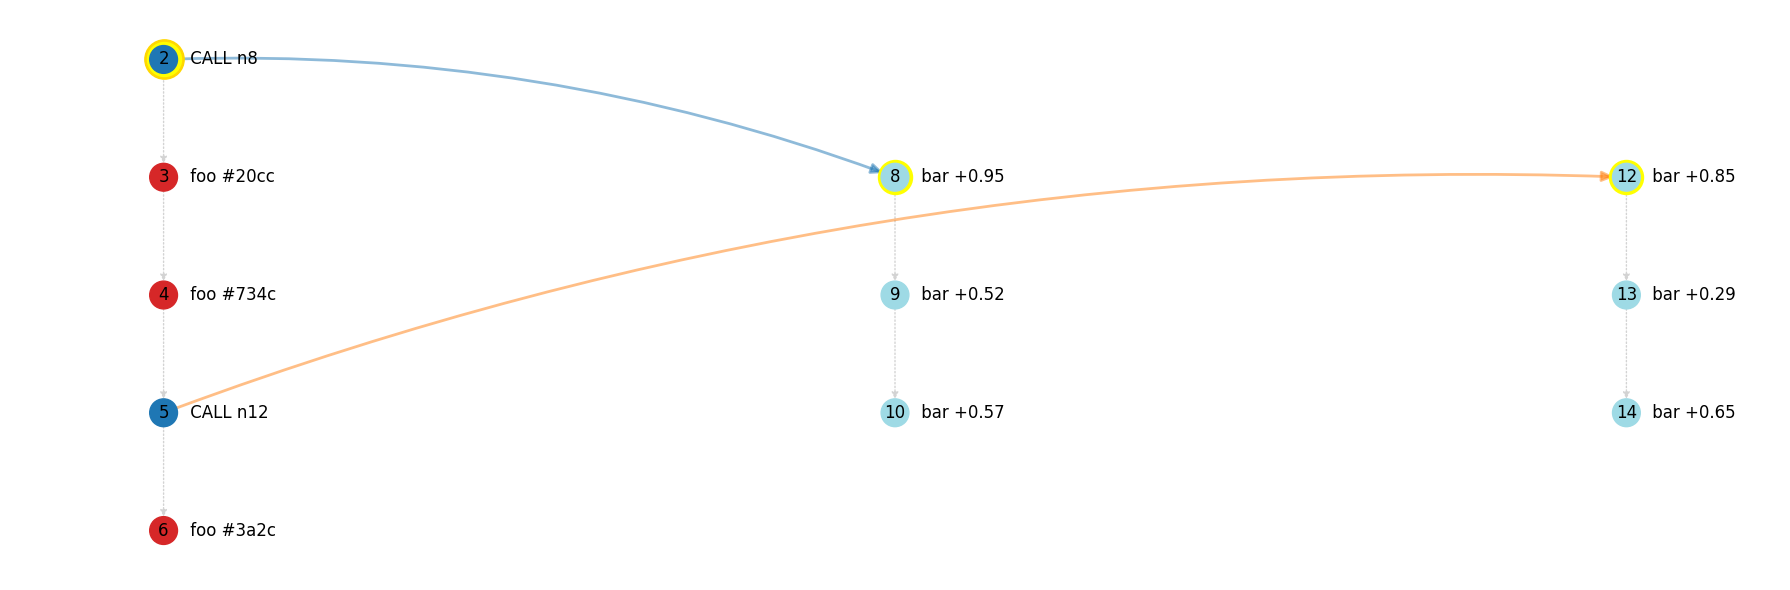

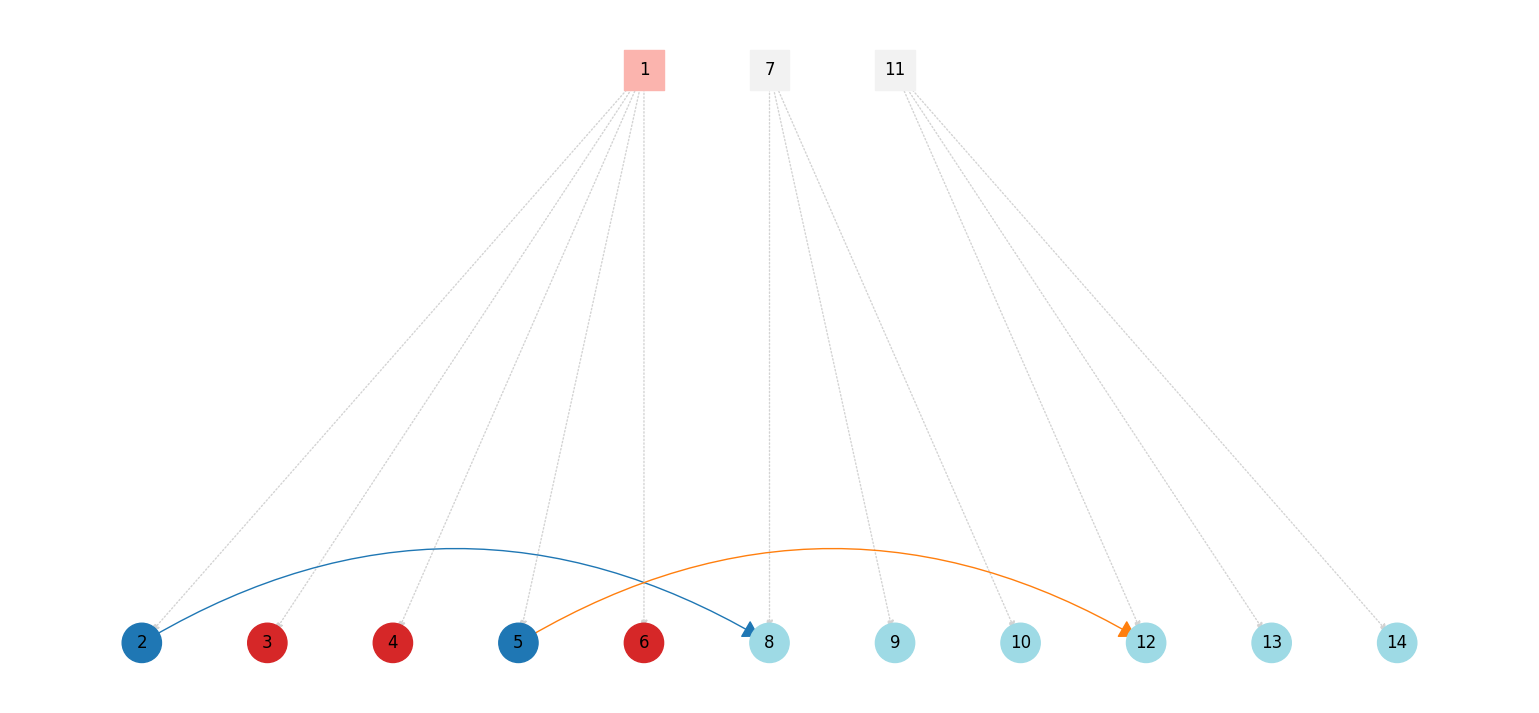

In [5]:
macro_foo = byron.f.macro('foo #{num:04x}', num=byron.f.integer_parameter(0, 2 ** 16))
macro_bar = byron.f.macro('bar {num:+0.2g}', num=byron.f.float_parameter(-1, 1))
external_frame = byron.f.bunch([macro_bar], size=3)
macro_ref = byron.f.macro('CALL {ref}', ref=byron.f.global_reference(external_frame, creative_zeal=1, first_macro=True))
main_frame = byron.f.bunch([macro_foo, macro_ref], size=5)

byron.f.as_text(main_frame)
byron.f.as_lgp(main_frame)
byron.f.as_forest(main_frame)

Labels may be tweaked in different ways

; 🖋 n1 ➜ Frame❬MacroArray#9❭
CALL n8  ; 🖋 n1.n2 ➜ Macro❬User#8❭
foo #20cc  ; 🖋 n1.n3 ➜ Macro❬User#1❭
foo #734c  ; 🖋 n1.n4 ➜ Macro❬User#1❭
CALL n12  ; 🖋 n1.n5 ➜ Macro❬User#8❭
foo #3a2c  ; 🖋 n1.n6 ➜ Macro❬User#1❭
; 🖋 n7 ➜ Frame❬MacroArray#8❭
PROC n8:
bar +0.95  ; 🖋 n7.n8 ➜ Macro❬User#7❭
bar +0.52  ; 🖋 n7.n9 ➜ Macro❬User#7❭
bar +0.57  ; 🖋 n7.n10 ➜ Macro❬User#7❭
; 🖋 n11 ➜ Frame❬MacroArray#8❭
PROC n12:
bar +0.85  ; 🖋 n11.n12 ➜ Macro❬User#7❭
bar +0.29  ; 🖋 n11.n13 ➜ Macro❬User#7❭
bar +0.65  ; 🖋 n11.n14 ➜ Macro❬User#7❭


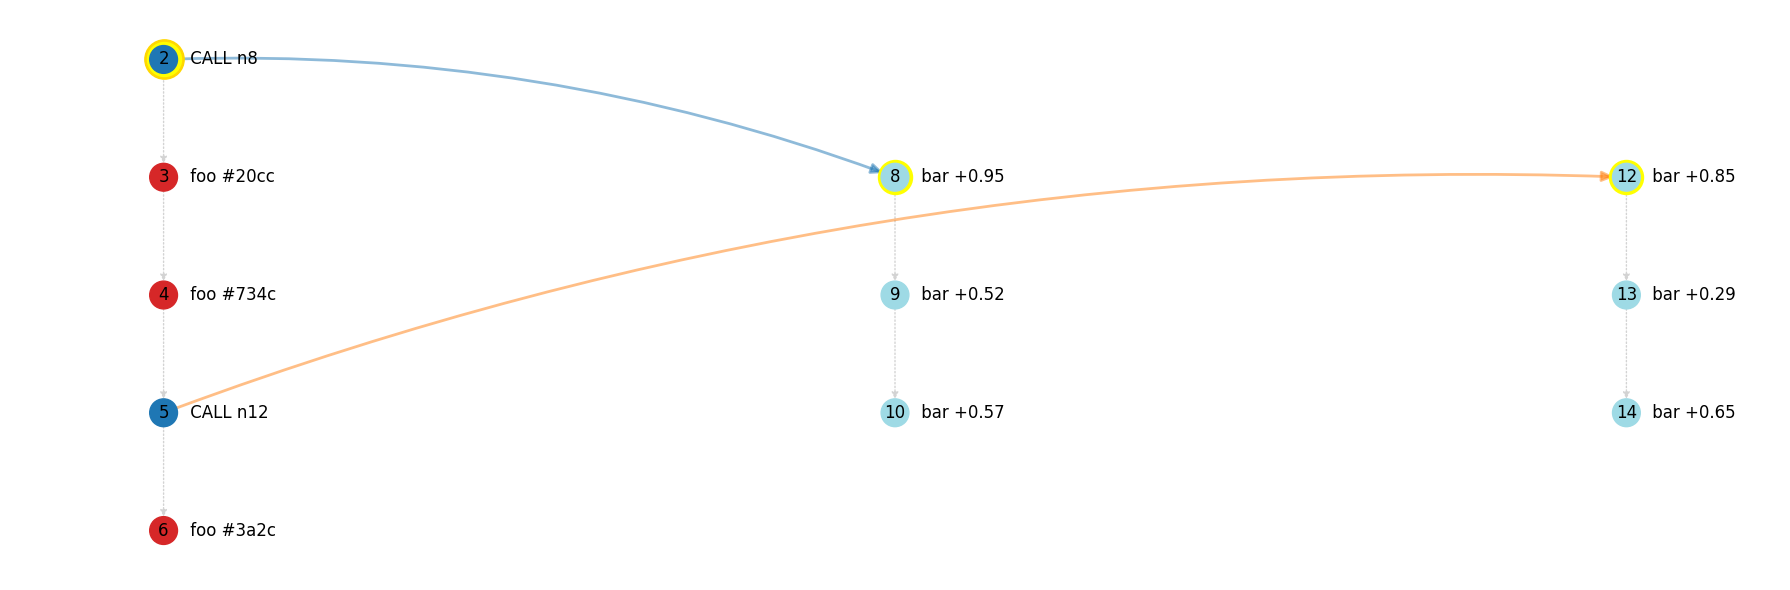

In [6]:
macro_foo = byron.f.macro('foo #{num:04x}', num=byron.f.integer_parameter(0, 2 ** 16))
macro_bar = byron.f.macro('bar {num:+0.2g}', num=byron.f.float_parameter(-1, 1), _label='PROC {_node}:\n')
external_frame = byron.f.bunch([macro_bar], size=3)
macro_ref = byron.f.macro('CALL {ref}', ref=byron.f.global_reference(external_frame, creative_zeal=1, first_macro=True))
main_frame = byron.f.bunch([macro_foo, macro_ref], size=5)

byron.f.as_text(main_frame)
byron.f.as_lgp(main_frame)

However, forcing a custom `_label` in *macro_bar* would use it everywhere a macro_bar is used. It is better to create a special macro just for the first line and customize it.

; 🖋 n1 ➜ Frame❬MacroArray#11❭
bar -0.81  ; 🖋 n1.n2 ➜ Macro❬User#2❭
bar +0.95  ; 🖋 n1.n3 ➜ Macro❬User#2❭
bar +0.52  ; 🖋 n1.n4 ➜ Macro❬User#2❭
CALL n9  ; 🖋 n1.n5 ➜ Macro❬User#9❭
foo #d2a0  ; 🖋 n1.n6 ➜ Macro❬User#1❭
CALL n9  ; 🖋 n1.n7 ➜ Macro❬User#9❭
; 🖋 n8 ➜ Frame❬FrameSequence#3❭
PROC n9:
; ini n9  ; 🖋 n8.n9 ➜ Macro❬Text#1❭
; 🖋 n8.n10 ➜ Frame❬MacroArray#10❭
bar -0.26  ; 🖋 n8.n10.n11 ➜ Macro❬User#2❭
foo #ed40  ; 🖋 n8.n10.n12 ➜ Macro❬User#1❭
bar +0.29  ; 🖋 n8.n10.n13 ➜ Macro❬User#2❭


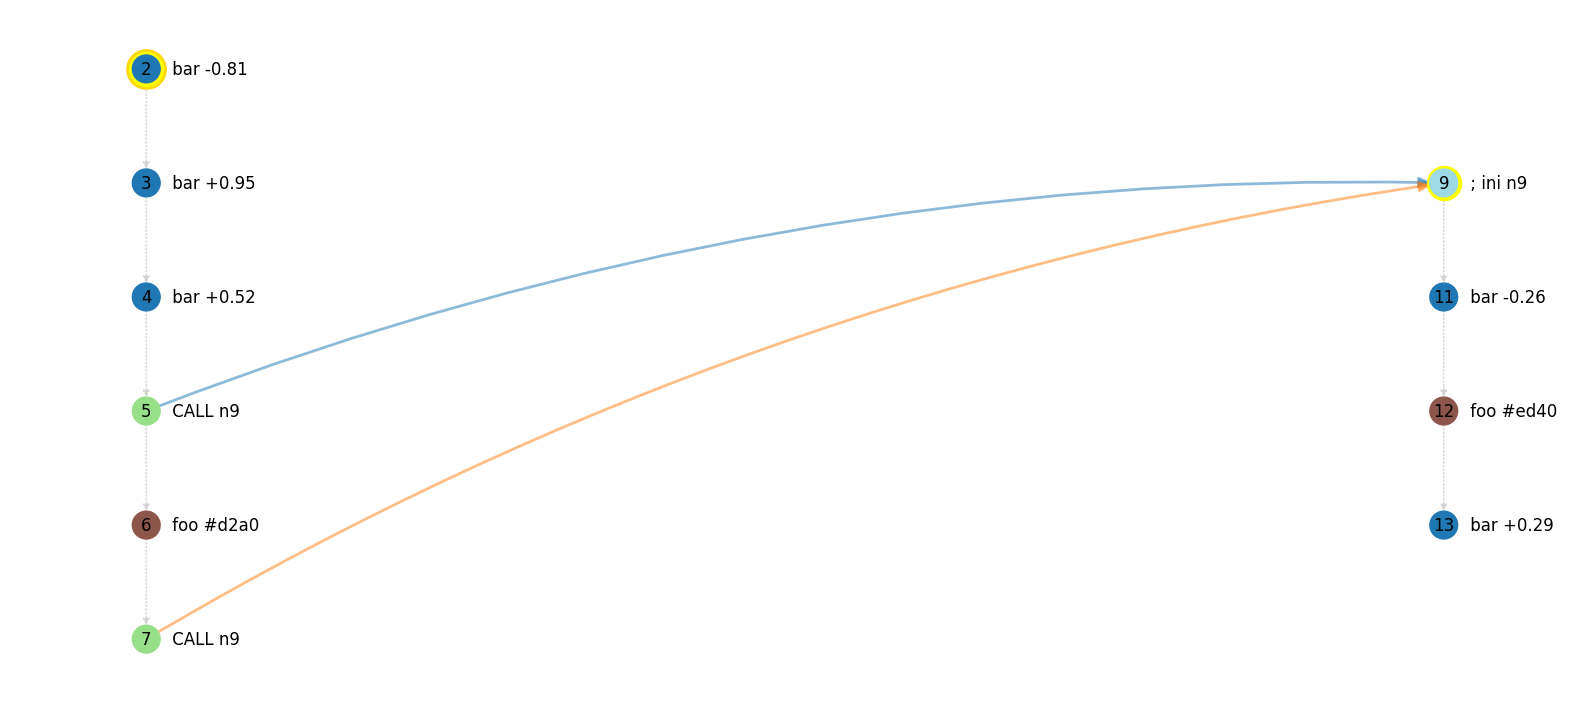

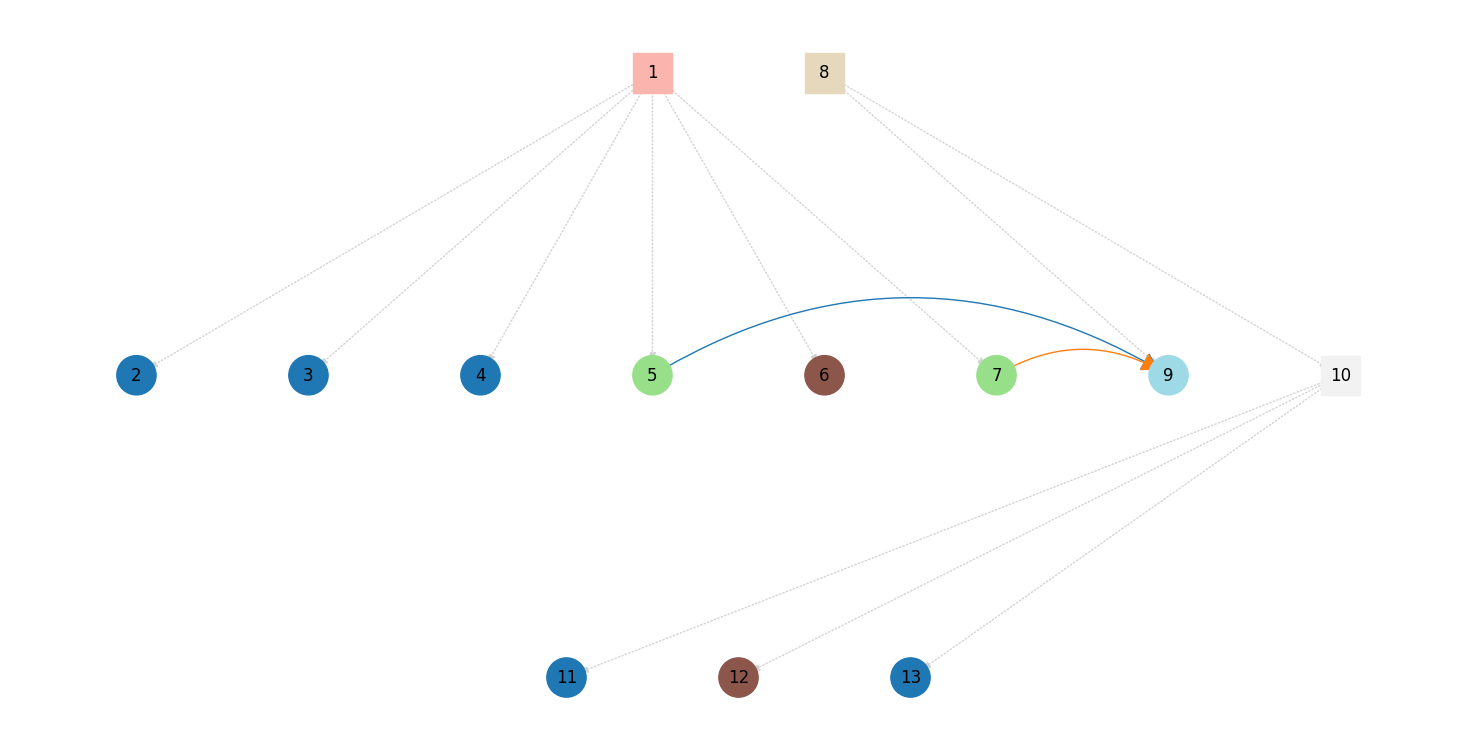

In [7]:
macro_foo = byron.f.macro('foo #{num:04x}', num=byron.f.integer_parameter(0, 2 ** 16))
macro_bar = byron.f.macro('bar {num:+0.2g}', num=byron.f.float_parameter(-1, 1))
sub_header = byron.f.macro('; ini {_node}', _label='PROC {_node}:\n')
subroutines = byron.f.sequence([sub_header, byron.f.bunch([macro_foo, macro_bar], size=3)])
macro_call = byron.f.macro('CALL {ref}', ref=byron.f.global_reference(subroutines, creative_zeal=1, first_macro=True))
main_frame = byron.f.bunch([macro_foo, macro_bar, macro_call], weights=(1, 1, 1), size=6)

byron.f.as_text(main_frame)
byron.f.as_lgp(main_frame)
byron.f.as_forest(main_frame)

By default external frames are dumped after the main one, burt the order may be tweaked. In the example, using *force_parent*, `n10` (the beginning of the tree containing subroutines, *Frame❬FrameSequence#4❭*) is dumped after `n2` (the placeholder, *Macro❬Text#2❭*)

; 🖋 n1 ➜ Frame❬FrameSequence#5❭
; 🖋 n1.n2 ➜ Macro❬Text#2❭
; 🖋 n10 ➜ Frame❬FrameSequence#4❭
PROC n11:
; init n11  ; 🖋 n10.n11 ➜ Macro❬Text#3❭
; 🖋 n10.n12 ➜ Frame❬MacroArray#12❭
bar -0.26  ; 🖋 n10.n12.n13 ➜ Macro❬User#2❭
foo #ed40  ; 🖋 n10.n12.n14 ➜ Macro❬User#1❭
bar +0.29  ; 🖋 n10.n12.n15 ➜ Macro❬User#2❭
; 🖋 n1.n3 ➜ Frame❬MacroArray#13❭
bar -0.81  ; 🖋 n1.n3.n4 ➜ Macro❬User#2❭
bar +0.95  ; 🖋 n1.n3.n5 ➜ Macro❬User#2❭
bar +0.52  ; 🖋 n1.n3.n6 ➜ Macro❬User#2❭
CALL n11  ; 🖋 n1.n3.n7 ➜ Macro❬User#10❭
foo #d2a0  ; 🖋 n1.n3.n8 ➜ Macro❬User#1❭
CALL n11  ; 🖋 n1.n3.n9 ➜ Macro❬User#10❭


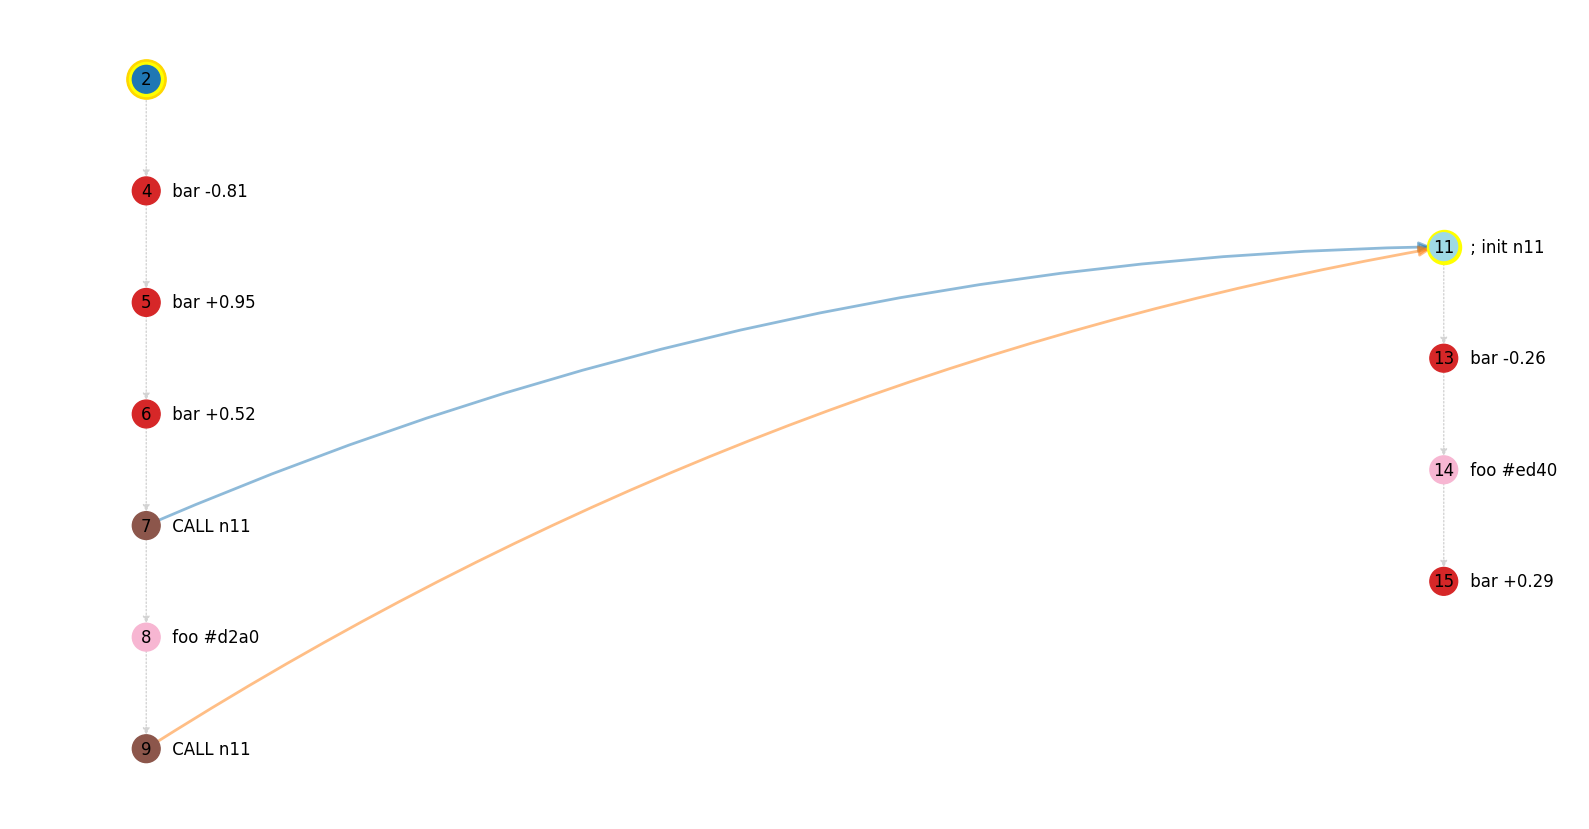

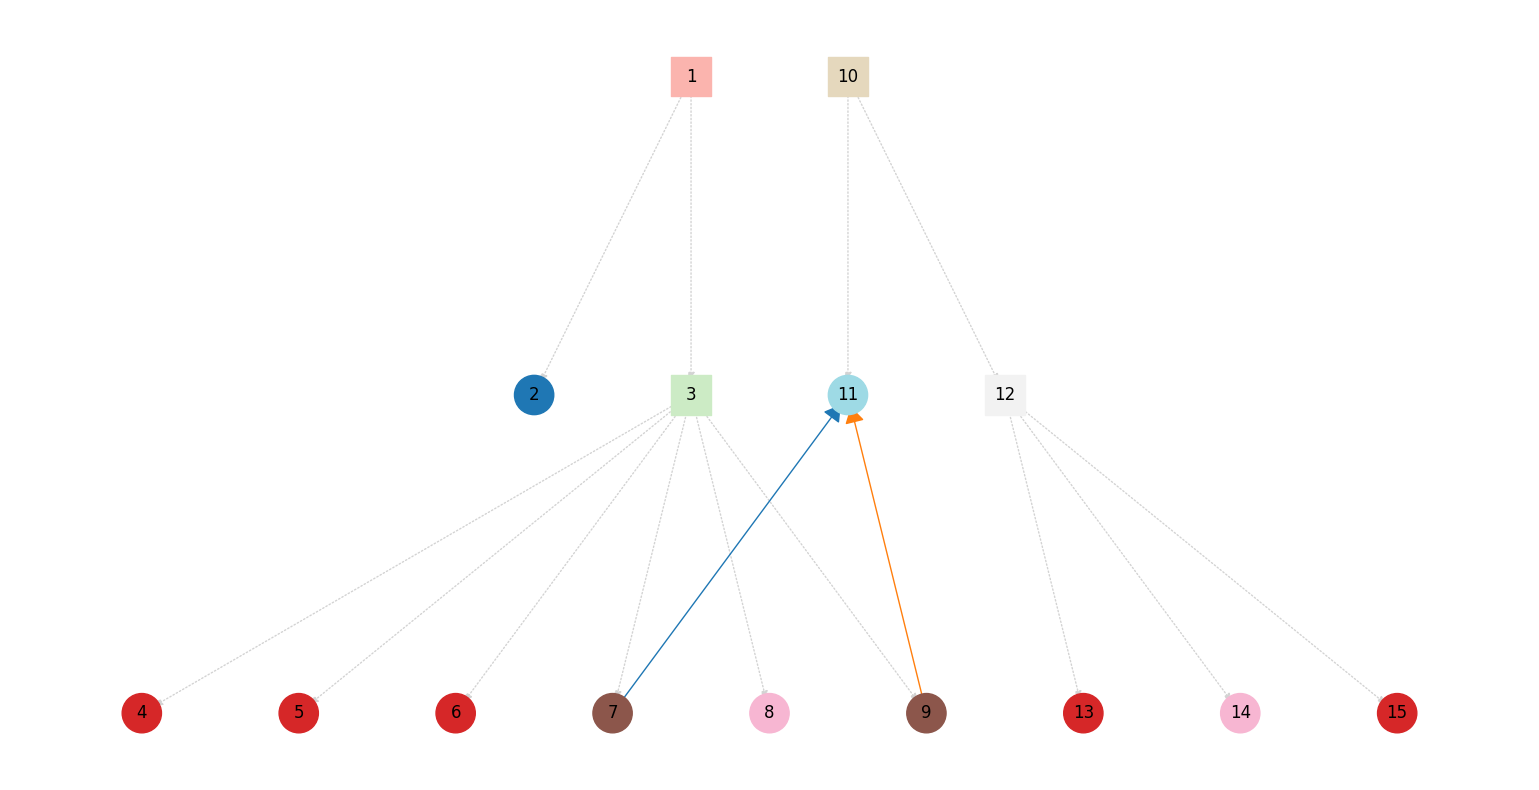

In [8]:
placeholder = byron.f.macro('')
macro_foo = byron.f.macro('foo #{num:04x}', num=byron.f.integer_parameter(0, 2 ** 16))
macro_bar = byron.f.macro('bar {num:+0.2g}', num=byron.f.float_parameter(-1, 1))
sub_header = byron.f.macro('; init {_node}', _label='PROC {_node}:\n')
subroutines = byron.f.sequence([sub_header, byron.f.bunch([macro_foo, macro_bar], size=3)])
macro_call = byron.f.macro('CALL {ref}', ref=byron.f.global_reference(subroutines, creative_zeal=1, first_macro=True))
main_frame = byron.f.sequence(
    [placeholder, byron.f.bunch([macro_foo, macro_bar, macro_call], weights=(1, 1, 1), size=6)]
)
subroutines.force_parent(placeholder)

byron.f.as_text(main_frame)
byron.f.as_lgp(main_frame)
byron.f.as_forest(main_frame)